In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline


In [4]:
import numpy
import scipy
import matplotlib
import matplotlib.dates as mpd
import pylab as plt
import datetime as dtm
import pytz
import multiprocessing as mpp
import pickle
import os
import json
import subprocess
import h5py
#
import numba
try:
    from numba.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
    import warnings
    warnings.simplefilter('ignore', category=Warning)
    warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
    warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)
except:
    print('** WARNING: Probably numba warnings not loading correctly; probably a versioning thing.')
#
# TODO: phase out unreferenced hpc_lib calls...
import hpc_lib
#
import platform
print('*** Python Version: ', platform.python_version())
#
system_name='owners_h5'
# system_name='SERC'
groups_fname=None

groups_fname='mazama_groups.json'
#
#data_file_name='data/sacct_mazama_out_2.out'
#data_file_name = 'data/mazama_usage_20200506_tool8.out'
#data_file_name = 'data/sacct_mazama_out_20200506a.out'

#data_file_name = 'data/sacct_owners_out_3500489.out'

#data_file_name = 'data/sacct_serc_20200622.out'
#data_file_name = 'data/sacct_serc_20200724.out'
#data_file_name = 'data/sacct_mazama_0623_tool8.out'
#data_file_name = 'data/sacct_mazama_20200820.out'

#h5_input = 'data/owners_jobs_sum.h5'
h5_input = 'data/sacct_mazama_20200820.h5'

output_path = 'output/{}_HPC_analytics'.format(system_name)
#output_path = 'output/HPC_analytics'
#
do_test_run = False
if do_test_run:
    # make a test set:
    k_max=10000
    with open(data_file_name, 'r') as fin:
        #
        nm, ext = os.path.splitext(data_file_name)
        data_file_test_name = '{}_test{}'.format(nm,ext)
        #
        print('** * {}'.format(data_file_test_name))
        #
        with open(data_file_test_name, 'w') as fout:
            for k, rw in enumerate(fin):
                fout.write(rw)
                if k >= k_max:
                    break
                #
            #
        #
    data_file_name = data_file_test_name
    system_name='{}_test'.format(system_name)
    output_path = 'output/{}_HPC_analytics'.format(system_name)
    #

print('*** data_File_name: {}'.format(h5_input))
print('*** output path: {}'.format(output_path))
print('*** system_name: {}'.format(system_name))

** WARNING: Probably numba warnings not loading correctly; probably a versioning thing.
*** Python Version:  3.7.3
*** data_File_name: data/sacct_mazama_20200820.h5
*** output path: output/owners_h5_HPC_analytics
*** system_name: owners_h5


**  ('time', 't_start', 'cpu_hours', 'N_jobs')
***  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqGRES', 'AllocGRES', 'JobID_parent')
** **  [b'twohour' b'twohour' b'twohour' b'twohour' b'twohour' b'twohour'
 b'twohour' b'twohour' b'twohour' b'twohour']


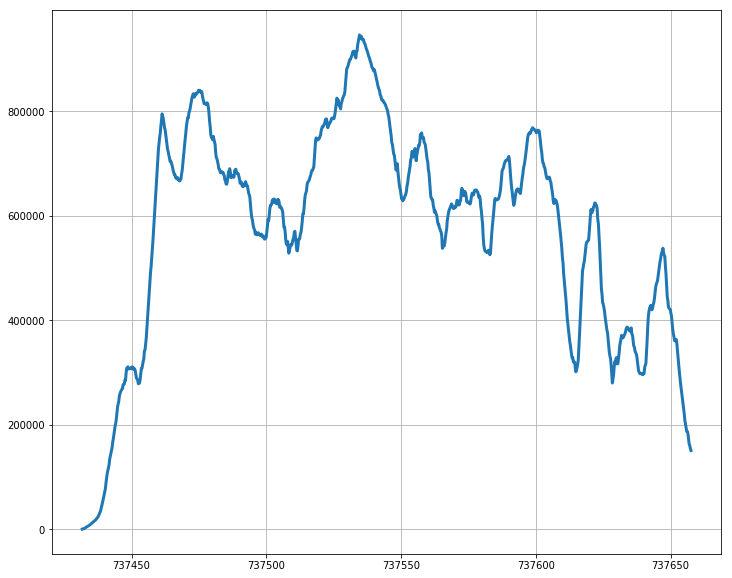

In [5]:
sacct_obj = hpc_lib.SACCT_data_from_h5(h5in_file=h5_input)

print('** ', sacct_obj.weekly_hours.dtype.names)

# Now, run a bunch of groups:
print('*** ', sacct_obj.jobs_summary.dtype.names)
print('** ** ', sacct_obj.jobs_summary['Partition'][0:10])
#
fg = plt.figure(figsize=(12,10))
ax1 = plt.subplot('111')
ax1.grid()
#
ax1.plot(sacct_obj.weekly_hours['time'], sacct_obj.weekly_hours['cpu_hours'], ls='-', marker='', lw=3.)


In [6]:
# h5_filename='{}.h5'.format(os.path.splitext(data_file_name)[0] )
# #
# print('h5_filename: ', h5_filename)

# #
# with h5py.File(h5_filename, 'w'):
#     pass
# obj = sacct_obj

# for ary,nm in zip([obj.jobs_summary, obj.cpu_usage, obj.weekly_hours, obj.daily_hours],
#                   ['jobs_summary', 'cpu_usage', 'weekly_hours', 'daily_hours']):
#     #
#     print('doing dataset: {}'.format(nm) )
#     #
#     hpc_lib.array_to_hdf5_dataset(input_array=ary, dataset_name=nm, output_fname=h5_filename, h5_mode='a',
#                                   verbose=1)

In [10]:
def compute_vol_distributions(sacct_obj, x_col='NNodes'):
    print('** ', sacct_obj.jobs_summary.dtype.names)
    X = sacct_obj.jobs_summary
    #A
    compute_volume = X['NCPUS']*X['Elapsed']
    #N1, N2 = numpy.unique(X['NCPUS'])[numpy.array([0,-1])]
    #cv_dist_ncpu = {k:0 for k in range(N1, N2+1)}
    #
    N1,N2 = numpy.unique(X[x_col])[numpy.array([0,-1])]
    #
    # given the simplicty of continuous, sequential indexing, use an rray. 
    cv_dist = numpy.zeros(shape=(N2-N1+1,), dtype=[(x_col, '>i8'), ('pdf', '>f8'), ('cdf', '>f8')]  )
    #cv_dist = numpy.zeros(size=(N2-N1+1, 3))
    cv_dist[x_col] = numpy.arange(N1,N2+1)
    #
    #cv_dist = {k:0 for k in range(N1,N2+1)}
    #cv_dist = numpy.array( shape=(N2-N1+1,) dtype=[(x_col, '>f8'), ('Y', '>f8')])
    #
    #for n_c, n_n,v in zip(X['NCPUS'], X['NNodes'], compute_volume):
    for n, v in zip(X[x_col], compute_volume):
        #cv_dist_ncpu[n_c] += v
        #cv_dist_nnode[n_n] += v
        cv_dist['pdf'][n] += v
    cv_dist['cdf']=numpy.cumsum(cv_dist['pdf'])

    #cv_sum_cpu  = {ky:vl for ky, vl in zip(cv_dist_ncpu.keys(), numpy.cumsum(list(cv_dist_ncpu.values())))}
    #cv_sum_node = {ky:vl for ky, vl in zip(cv_dist_nnode.keys(), numpy.cumsum([x for x in cv_dist_ncpu.values()]))}
    #
    return cv_dist

XX = compute_vol_distributions(sacct_obj)



**  ('index', 'User', 'Group', 'GID', 'JobName', 'JobID', 'JobIDRaw', 'Partition', 'State', 'Timelimit', 'NCPUS', 'NNodes', 'Submit', 'Eligible', 'Start', 'End', 'Elapsed', 'SystemCPU', 'UserCPU', 'TotalCPU', 'NTasks', 'CPUTimeRAW', 'Suspended', 'ReqGRES', 'AllocGRES', 'JobID_parent')


IndexError: index 1333 is out of bounds for axis 0 with size 1333

nodes, pdf, cdf
1: 0.5512505891002318, 0.5512505891002318
2: 0.023185507773624506, 0.5744360968738564
3: 0.24706516591398747, 0.821501262787844
4: 0.08316046876425633, 0.9046617315521003
5: 0.010573208111716394, 0.9152349396638167
6: 0.006220935076196685, 0.9214558747400133
7: 0.017850607603616134, 0.9393064823436295
8: 0.04466154105023791, 0.9839680233938674
9: 0.0010445083733436659, 0.985012531767211
10: 0.008020107653236684, 0.9930326394204477
11: 0.0009516725367192463, 0.993984311957167
12: 0.0017895244412030548, 0.99577383639837


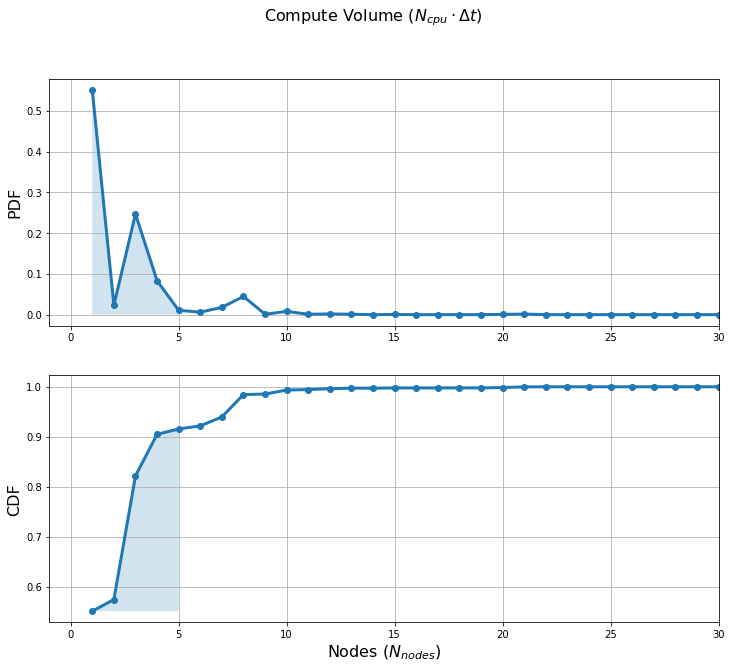

In [102]:
def compute_vol_distributions_report(sacct_obj, x_col='NNodes', normed=True, figsize=None, ax1=None, ax2=None):
    #
    
    if figsize is None:
        figsize=(12,10)
    if ax1 is None or ax2 is None:
        # valid axes not provided:
        fg = plt.figure(figsize=figsize)
    
        ax1 = fg.add_subplot('211')
        ax2 = fg.add_subplot('212', sharex=ax1)
        ax1.grid()
        ax2.grid()
    else:
        fg = ax1.figure
    #
    x,y = zip(*cv_dist_nnode.items())
    if normed:
        y /= numpy.sum(y)
    y_cum = numpy.cumsum(y)

    #N_y = numpy.sum(y)

    ax1.plot(x,y, ls='-', marker='o', lw=3)
    #ix = X['Submit'].argsort()
    #ax1.plot(X['Submit'][ix], compute_volume[ix], ls='-', marker='', lw=3)
    #
    #x,y = zip(*cv_sum_node.items())
    ax2.plot(x,y_cum, ls='-', marker='o', lw=3)
    #
    ax1.fill_between(x[0:5], (y)[0:5], numpy.ones(5)*0., alpha=.2)
    ax2.fill_between(x[0:5], (y_cum)[0:5], numpy.ones(5)*y_cum[0], alpha=.2)
    #
    ax1.set_xlim(-1, 30)
    #ax2.set_ylim(0., 1.1)
    #
    fg.suptitle('Compute Volume $(N_{cpu} \cdot \Delta t)$', size=16)
    ax1.set_ylabel('PDF', size=16)
    ax2.set_ylabel('CDF', size=16)
    ax2.set_xlabel('Nodes ($N_{nodes}$)', size=16)

    print('nodes, pdf, cdf')
    for k, (n, p1, p2) in enumerate(zip(x, y, y_cum)):
        print('{}: {}, {}'.format(n,p1,p2))
        #
        if k>10:break
    #
    # print('*** PDF[0:10]: ', (y/N_y)[0:10])
    # print('*** CDF[0:10]: ', (y_cum/N_y)[0:10])

In [92]:
print('** ', 128/24)
print('** ', 128*8)

**  5.333333333333333
**  1024


In [46]:
print('** ', numpy.unique(X['NCPUS']))
N1, N2 = numpy.unique(X['NCPUS'])[numpy.array([0,-1])]
print('** N1, N2: {}, {}'.format(N1, N2))
#
print('** ', numpy.unique(X['NNodes']))
N1, N2 = numpy.unique(X['NNodes'])[numpy.array([0,-1])]
print('** N1, N2: {}, {}'.format(N1, N2))

**  [   1    2    3    4    5    6    8    9   10   12   13   14   15   16
   18   19   20   22   24   26   28   30   32   34   36   40   44   48
   50   51   54   56   60   62   64   65   66   70   72   78   80   88
   96  100  101  102  110  120  126  128  132  144  150  160  192  198
  200  202  220  240  242  250  256  264  288  300  315  320  336  352
  360  384  396  400  432  480  500  502  511  576  720  864  960 1002
 3001 3002 6665]
** N1, N2: 1, 6665
**  [   1    2    3    4    5    6    7    8    9   10   11   12   13   14
   15   16   17   18   20   21   22   24   25   27   30   32   40   48
   63   64  128 1333]
** N1, N2: 1, 1333


In [106]:
SGRM = hpc_lib.SACCT_groups_analyzer_report_handler(Short_title='Owners Analytics', 
                                           Full_title='Owners HPC Analytics Composite Report',
                                          out_path='output/composite_report',
                                          tex_filename='Mazama_analytics_20200820_composite.tex',
                                         SACCT_obj=sacct_obj)

** n_records:  99
** partition:  twohour
** partition:  ere
** partition:  suprib
** partition:  cees
** partition:  suckale
** partition:  schroeder
** partition:  thomas
** partition:  gpu
** adding slide: slide_2
** adding slide: slide_3
** adding slide: slide_4
** adding slide: slide_5
** adding slide: slide_6
** adding slide: slide_7
** adding slide: slide_8
** adding slide: slide_9
** adding slide: slide_10
** adding slide: slide_11
** adding slide: slide_12
** adding slide: slide_13
** adding slide: slide_14
** adding slide: slide_15
** adding slide: slide_16
** adding slide: slide_17
** adding slide: slide_18
** adding slide: slide_19
** adding slide: slide_20
** adding slide: slide_21
** adding slide: slide_22
** adding slide: slide_23
** adding slide: slide_24
** adding slide: slide_25
** adding slide: slide_26
** adding slide: slide_27
** adding slide: slide_28


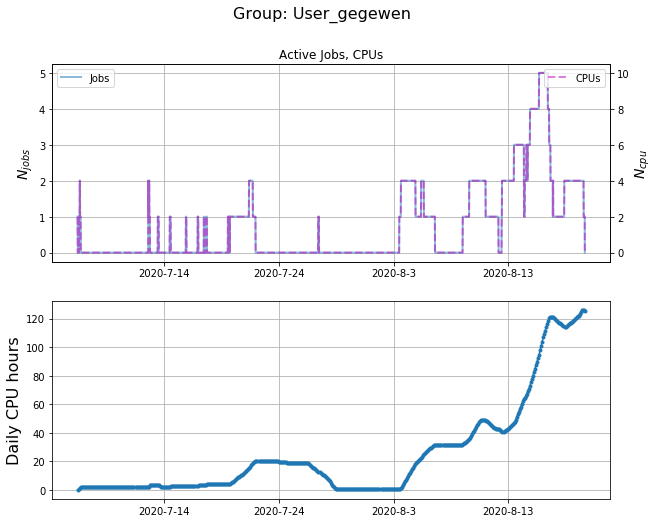

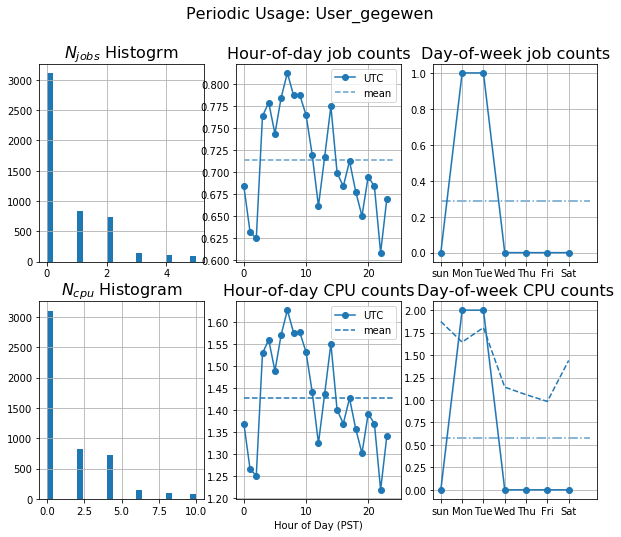

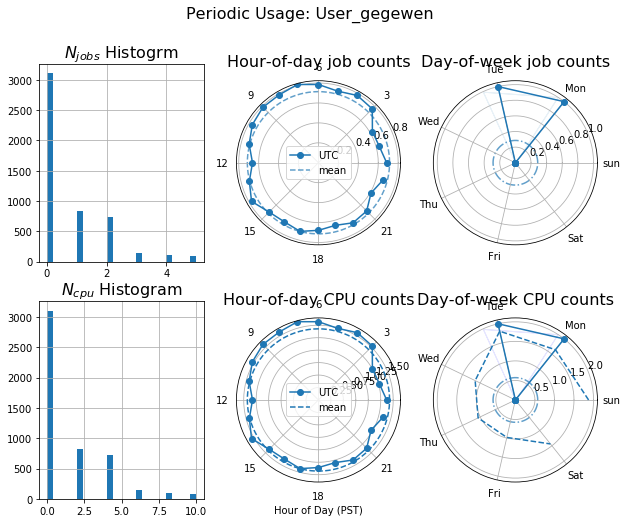

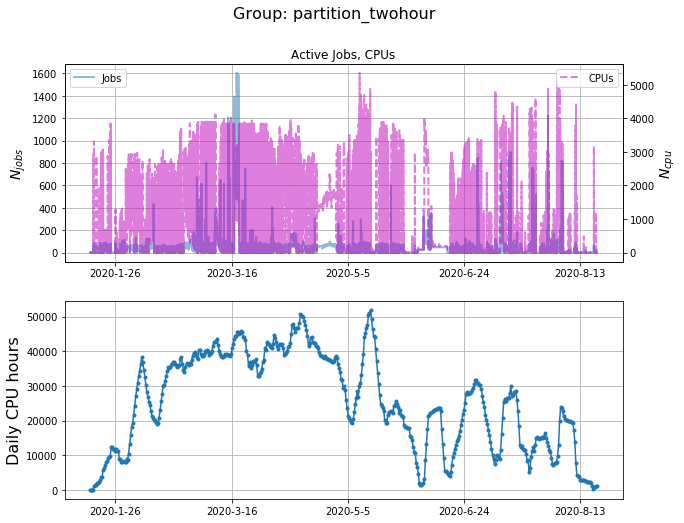

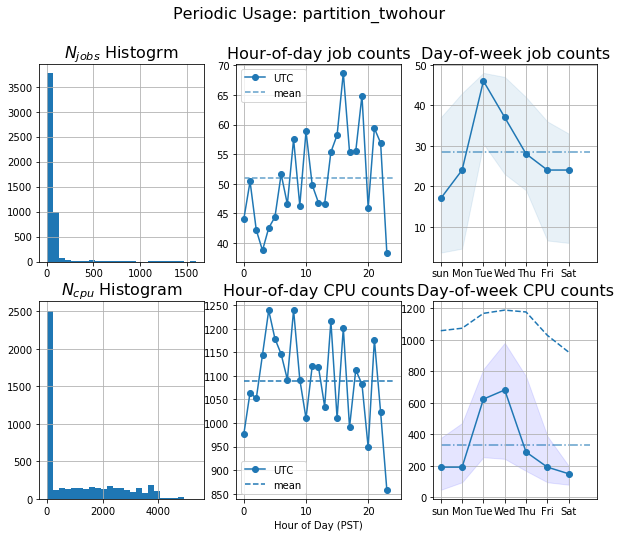

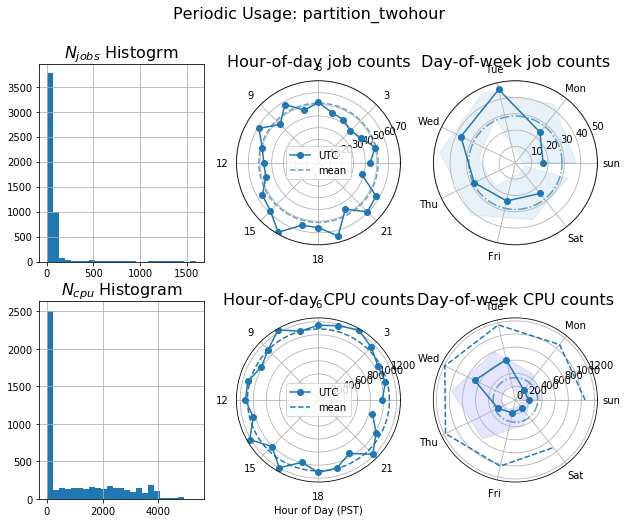

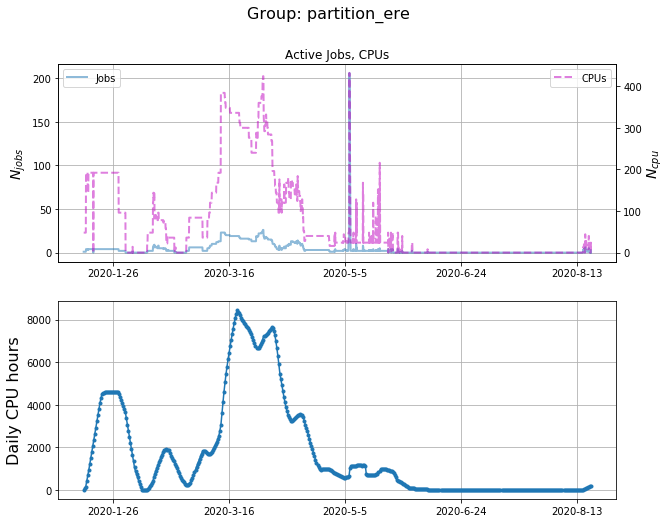

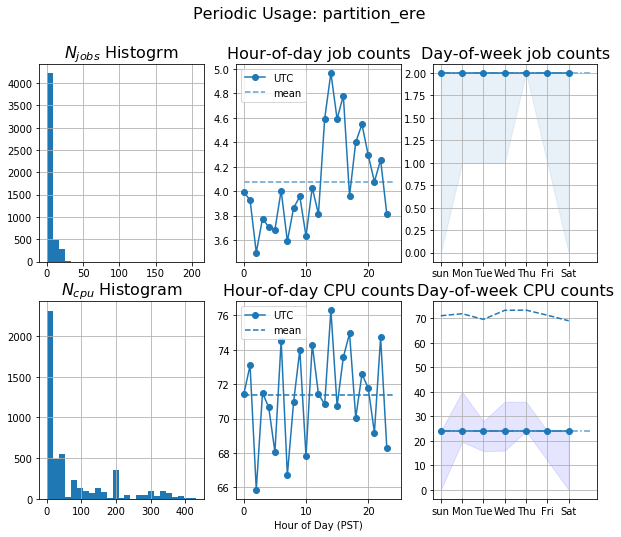

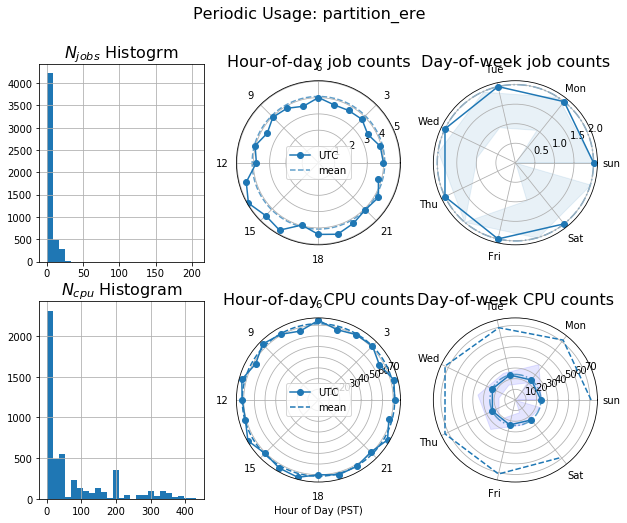

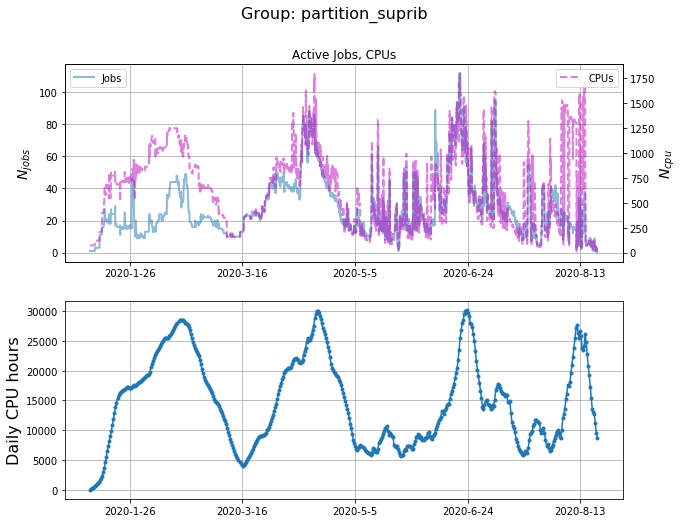

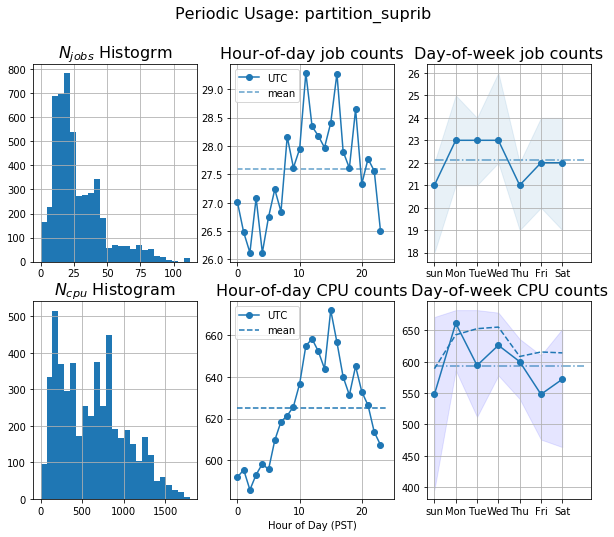

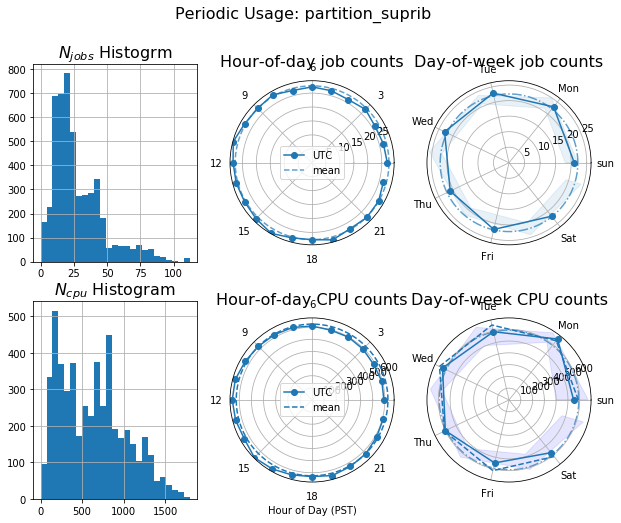

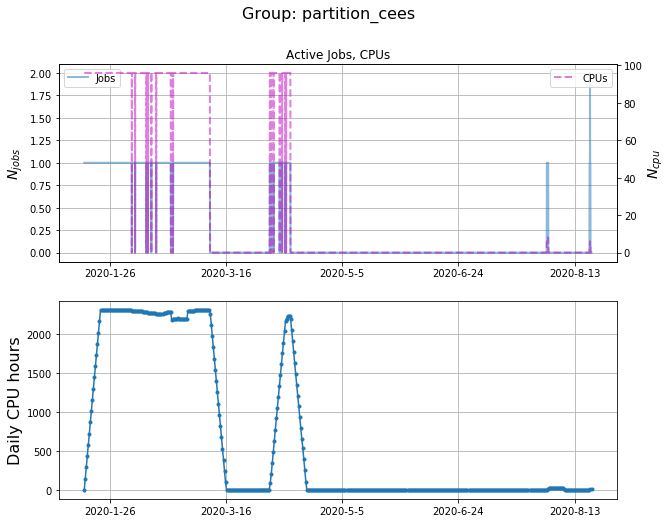

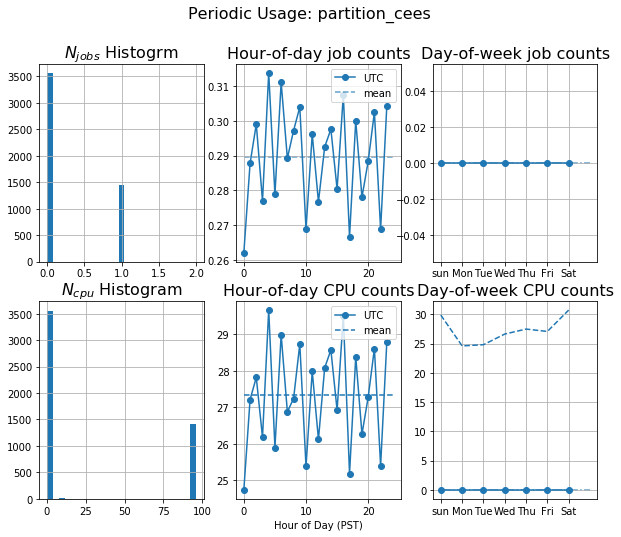

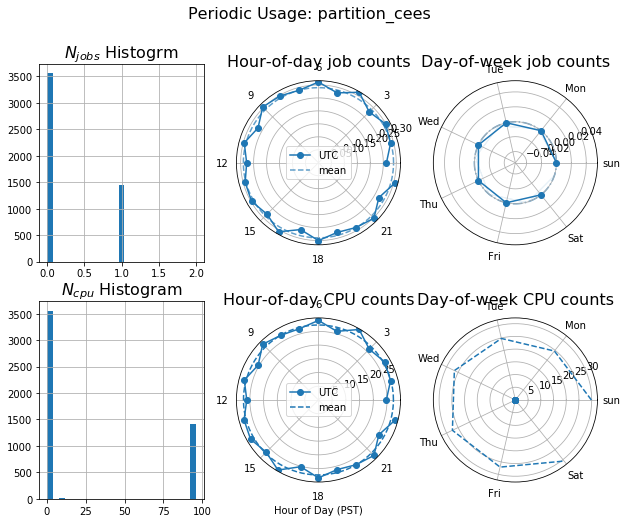

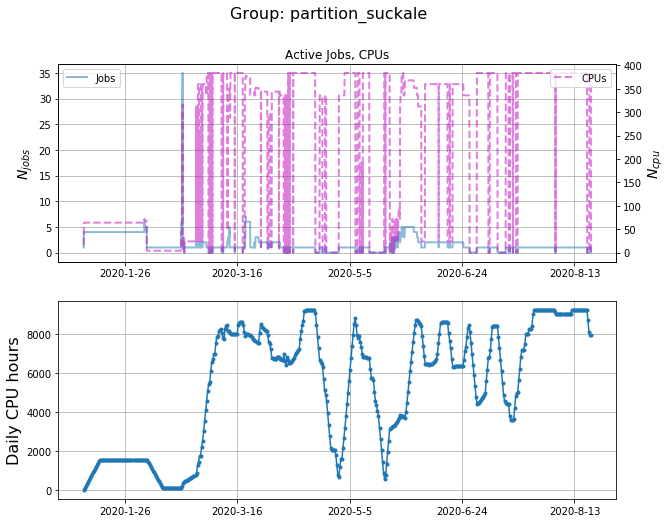

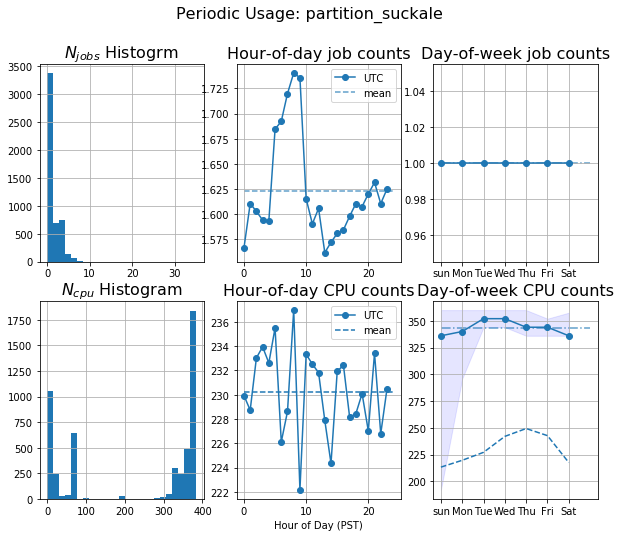

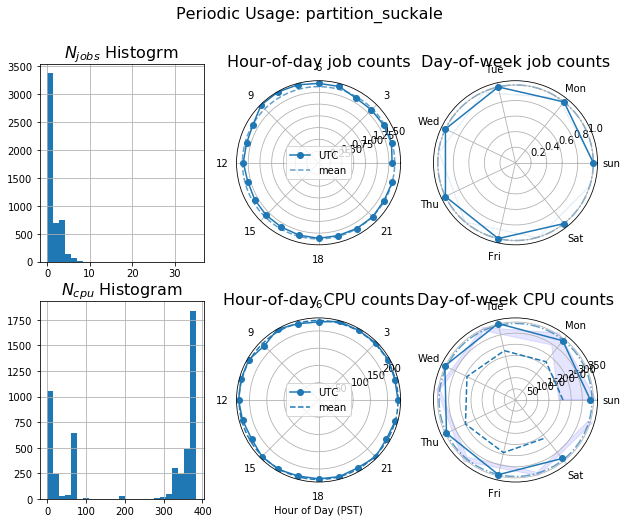

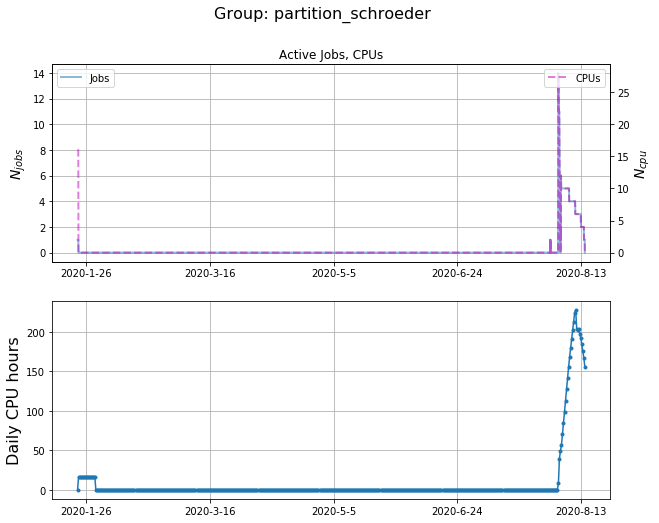

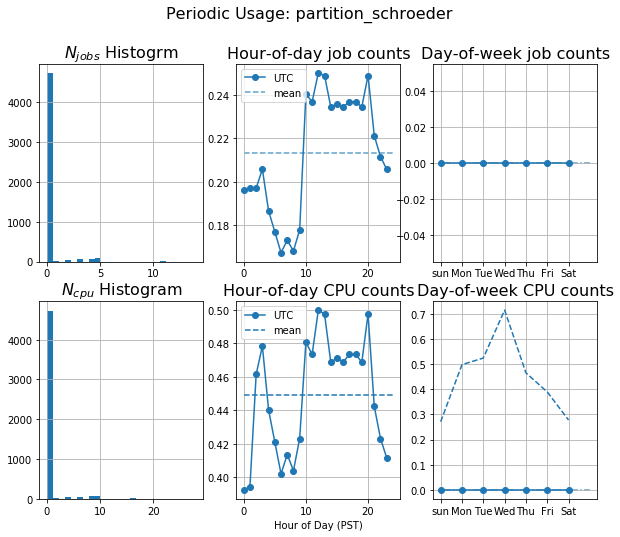

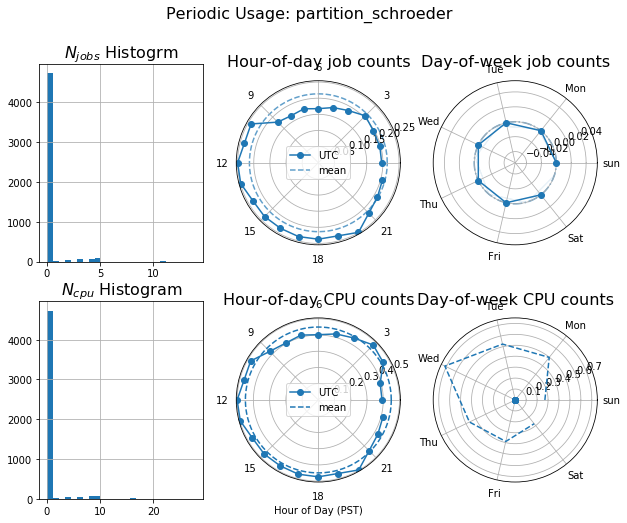

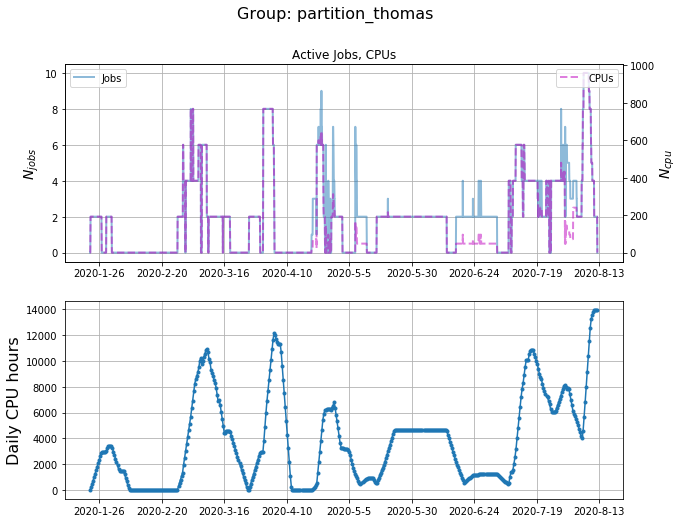

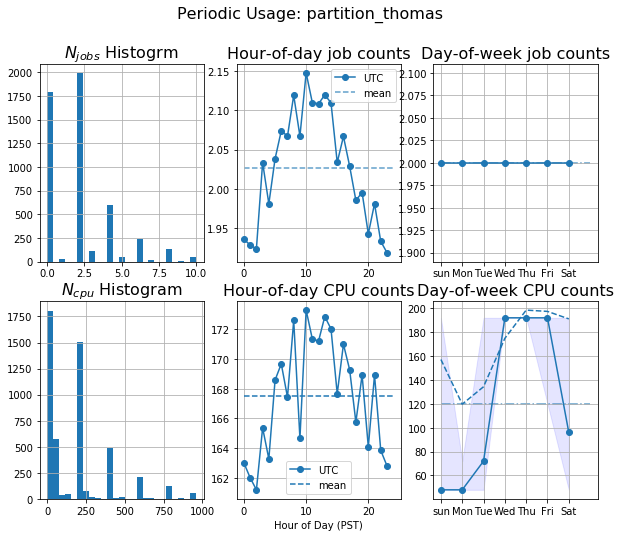

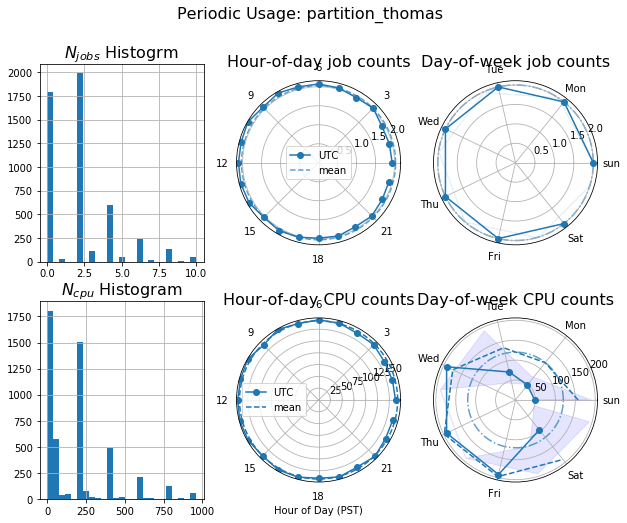

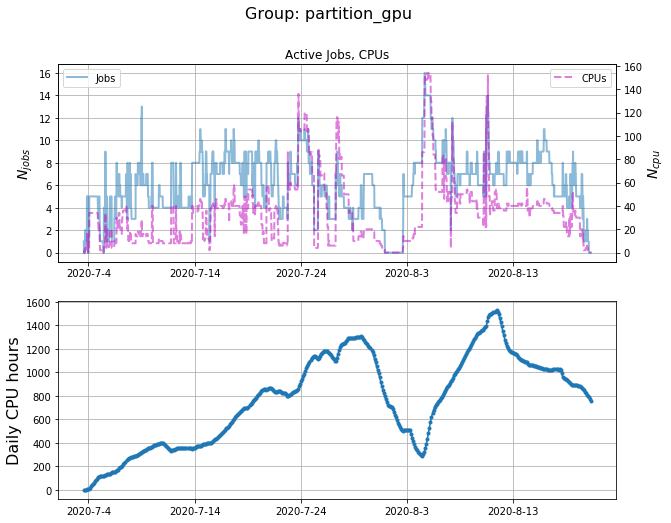

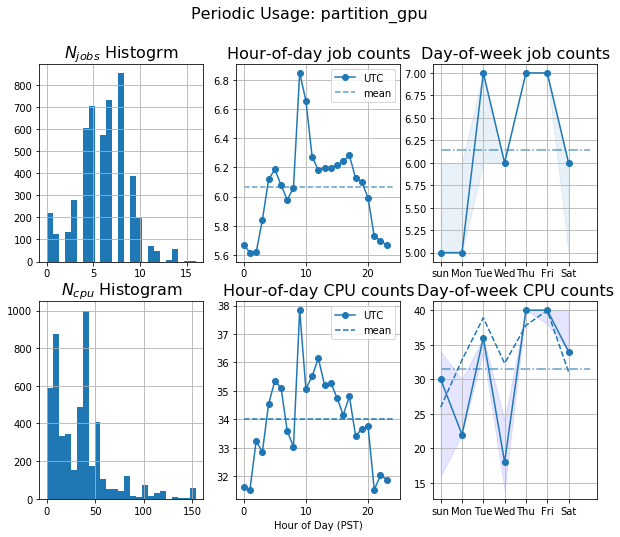

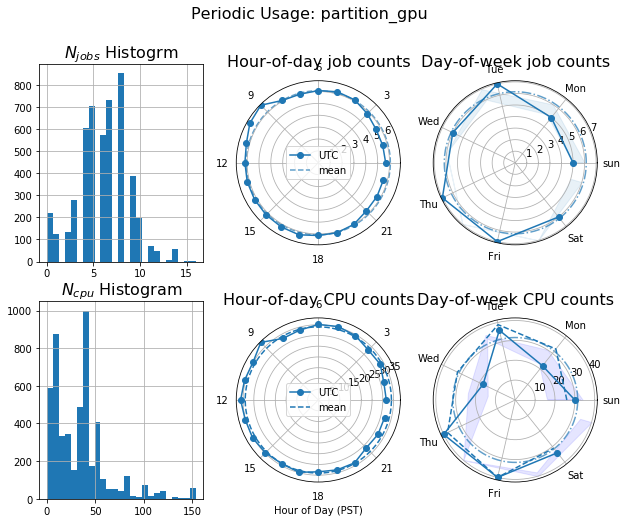

In [107]:
ix_g = sacct_mazama.jobs_summary['User']=='gegewen'
print('** n_records: ', numpy.sum(ix_g))
# out_path='output/gegewen'
rpt = SGRM.standard_reports_slides(ix=ix_g, group_name='User_gegewen')
#
for partition in ['twohour', 'ere', 'suprib', 'cees', 'suckale', 'schroeder', 'thomas', 'gpu', 'tgp']:
#for partition in ['ere', 'gpu']:
    print('** partition: ', partition)
    ix_p = sacct_mazama.jobs_summary['Partition']==partition
    rpt = SGRM.standard_reports_slides(ix=ix_p, group_name='partition_{}'.format(partition))
SGRM.HPC_tex_obj.render()

** adding slide: slide_2
** adding slide: slide_3
** adding slide: slide_4


In [ ]:
# print('*** my_cpu_: ', my_cpu_usage[0:20]==sacct_mazama.cpu_usage[0:20])
# print('*** my_cpu2: ', (my_cpu_usage==sacct_mazama.cpu_usage).all())

In [ ]:
print('** ', sacct_mazama.cpu_usage[500:510])
fg = plt.figure(figsize=(12,8))
ax = plt.gca()
ax.plot(sacct_mazama.cpu_usage['time'], sacct_mazama.cpu_usage['N_cpu'], ls='-')

In [ ]:
max_submit, max_start = [mpd.num2date(numpy.nanmax(sacct_mazama.jobs_summary[cl])) for cl in ['Start', 'Submit'] ]
print('*** max_submit: {}, max_start: {}'.format(*[mpd.num2date(numpy.nanmax(sacct_mazama.jobs_summary[cl])) for cl in ['Start', 'Submit'] ]))

In [ ]:
#
#cpu_usage = sacct_mazama.active_jobs_cpu()
cpu_usage = sacct_mazama.cpu_usage
#
bin_size=7
cpu_weekly = sacct_mazama.active_jobs_cpu(bin_size=bin_size, t_min=None)


In [ ]:
fg = plt.figure(figsize=(10,10))
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_usage['time'], cpu_usage['N_jobs'], ls='-', lw=2., marker='')
ax1.plot(cpu_weekly['time'], cpu_weekly['N_jobs'], ls='-', lw=2., marker='.')
#
ax2.plot(cpu_usage['time'], cpu_usage['N_cpu'], ls='-', lw=2., marker='')
ax2.plot(cpu_weekly['time'], cpu_weekly['N_cpu'], ls='-', lw=2., marker='.')
#

ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
#print('*** ', lbls)
#
ax2.set_xticklabels(lbls)



In [ ]:
print('*** ', sacct_mazama.jobs_summary['End'].shape)
print('*** ', (sacct_mazama.jobs_summary[None])['End'].shape)
print('*** ', (sacct_mazama.jobs_summary[(numpy.random.random(len(sacct_mazama.jobs_summary))>.8)])['End'].shape)

In [ ]:
# #my_ix = numpy.where(numpy.random.random(len(sacct_mazama.jobs_summary))>.75)
# my_weekly_hours = sacct_mazama.get_cpu_hours(bin_size=7, n_points=1000, IX=None)
# fg = plt.figure(figsize=(10,8))
# ax1 = plt.gca()
# ax1.grid()
# #
# ax1.plot(my_weekly_hours['time'], my_weekly_hours['cpu_hours']/7., ls='-', marker='.', label='bins=7 day', zorder=11)
# #ax1.plot(daily_hours['time'], daily_hours['cpu_hours'], ls='-', marker='.', label='bins=1 day', zorder=5)


# #
# fg.canvas.draw()
# #
# # set ax3 labels to dates:
# # now format the datestrings...
# lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
# #print('*** ', lbls)
# #
# ax1.set_xticklabels(lbls)
# ax1.set_xlabel('Time $t$')
# ax1.set_ylabel('Daily CPU hours')
# ax1.set_title('Daily CPU hours')
# #
# ax1.legend(loc=0)

#ax1.plot(daily_hours['time'][0::len(daily_hours)-1], numpy.ones(2)*123*48*24, ls='--', marker='', lw=3.)

In [ ]:
# TODO: these should (optionally? be integrated into the main object and pickled.)
#weekly_hours = sacct_mazama.get_cpu_hours(bin_size=7, n_points=1000)
weekly_hours = sacct_mazama.weekly_hours
daily_hours  = sacct_mazama.daily_hours

#daily_hours = sacct_mazama.get_cpu_hours(bin_size=1, n_points=1000)

In [ ]:
fg = plt.figure(figsize=(10,8))
ax1 = plt.gca()
ax1.grid()
#
ax1.plot(weekly_hours['time'], weekly_hours['cpu_hours']/7., ls='-', marker='.', label='bins=7 day', zorder=11)
ax1.plot(daily_hours['time'], daily_hours['cpu_hours'], ls='-', marker='.', label='bins=1 day', zorder=5)


#
fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
#print('*** ', lbls)
#
ax1.set_xticklabels(lbls)
ax1.set_xlabel('Time $t$')
ax1.set_ylabel('Daily CPU hours')
ax1.set_title('Daily CPU hours')
#
ax1.legend(loc=0)

ax1.plot(daily_hours['time'][0::len(daily_hours)-1], numpy.ones(2)*123*48*24, ls='--', marker='', lw=3.)
# ax1.plot(daily_hours['time'][0::len(daily_hours)-1], numpy.ones(2)*12*24*24, ls='--', marker='',
#          lw=3., color='r', label='CPU+GPU')
# ax1.plot(daily_hours['time'][0::len(daily_hours)-1], numpy.ones(2)*14*24*24, ls='--', marker='',
#          lw=3., color='g', label='CPU nodes')
# ax1.plot(daily_hours['time'][0::len(daily_hours)-1], numpy.ones(2)*12*24*8, ls='--', marker='',
#          lw=3., color='m',label='9 to 5')
#
ax1.legend(loc=0)
if not os.path.isdir(os.path.join(output_path, 'figs')):
    os.makedirs(os.path.join(output_path, 'figs'))
plt.savefig(os.path.join(output_path, 'figs', 'daily_cpu_hours_all.png'))

In [ ]:
# how many active nodes do we have? looks like tasks/cpus show up as 1/thread, so 48 per node, so...
n_max = numpy.max(daily_hours['cpu_hours'])
#
n_nodes = n_max/(24.*48.)
#
print('*** n_max={}, n_nodes={}'.format(n_max, n_nodes))
#140000/(24*48)

In [ ]:
# time of day(-like) compute volume requests.

qs = [.5, .75, .95]
#
# This is TotalCPU, UserCPU, and SystemCPU, so we don't need to compute it any longer.
comp_vol_submit = sacct_mazama.get_submit_compute_vol_timeofday(qs=qs)
comp_vol_start = sacct_mazama.get_submit_compute_vol_timeofday(time_col='Start', qs=qs)
#
fg = plt.figure(figsize=(12,6))
ax1 = fg.add_subplot('121')
ax2 = fg.add_subplot('122')
ax1.grid()
ax2.grid()
#

# N = numpy.sum(comp_vol_submit['cpu-time'])
N = 1.
ax1.plot(comp_vol_submit['time'], comp_vol_submit['cpu-time']/N,
         ls='-', marker='o', lw=2., label='submit')
#print('*** ', numpy.sum(comp_vol_submit['cpu-time']/numpy.sum(comp_vol_submit['cpu-time'])))
#
# N = numpy.sum(comp_vol_start['cpu-time'])
N = 1 
ax1.plot(comp_vol_start['time'], comp_vol_start['cpu-time']/N,
         ls='-', marker='o', lw=2., label='start')
#print('*** ', numpy.sum(comp_vol_start['cpu-time']/N))
#
#N=numpy.sum(comp_vol_submit['cpus'])
N=1.
ax2.plot(comp_vol_submit['time'], comp_vol_submit['cpus']/N, ls='-', marker='o', lw=2., label='submit')

#N=numpy.sum(comp_vol_start['cpus'])
N=1
ax2.plot(comp_vol_start['time'], comp_vol_start['cpus']/N, ls='-', marker='o', lw=2., label='start')
#
#for k,cl in enumerate(comp_vol_tod.dtype.names[2:]):
#    ax1.plot(comp_vol_tod['time'], comp_vol_tod[cl], ls='-', marker='o', lw=2., label='$q={}$'.format(qs[k]))
#    break
#
ax1.legend(loc=0, numpoints=1)
ax1.set_title('Compute Volume Requested, \n$N_{CPU} \cdot \Delta t_{limit}$')
ax1.set_xlabel('Hour of day')
ax2.set_ylabel('Compute Vol.')

ax2.set_title('CPUs Requested')
ax2.set_xlabel('Hour of day')
ax2.legend(loc=1, numpoints=1)

#ax1.set_yscale('log')

In [ ]:
zz = sacct_mazama.active_cpu_jobs_per_day_hour_report(qs=[.45, .5, .55],
                                        figsize=(14,10), cpu_usage=None, periodic_projection='polar')

In [ ]:
# compute some distributions:
print('*** ', sacct_mazama.jobs_summary.dtype.names)
run_times = sacct_mazama.get_run_times()

#
fg = plt.figure(figsize=(12,8))
ax1 = fg.add_subplot('221')
ax2 = fg.add_subplot('222')
#ax1a.set_yscale('log')
ax3 = fg.add_subplot('223')
ax4 = fg.add_subplot('224')
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()
#
hh = ax1.hist(run_times, bins=50, cumulative=False, normed=True, log=True)
hh1c = ax2.hist(run_times, bins=50, cumulative=True, normed=True, log=True, histtype='bar')
#hh1c = ax2.plot(sorted(run_times), numpy.array(numpy.linspace(1./len(run_times), 1.,
#                                                             len(run_times))), lw=3.0, zorder=11)
#
hh2 = ax3.hist(sacct_mazama.jobs_summary['NCPUS'], bins=50, normed=True, log=True)
hh22 = ax4.hist(sacct_mazama.jobs_summary['NCPUS'], bins=50, normed=True, log=True,
                 cumulative=True, histtype='bar', lw=3, zorder=11)
#hh22 = ax4.hist(sacct_mazama.jobs_summary['NCPUS'], bins=50, normed=True, log=True,
#                 cumulative=True, histtype='step', lw=3, zorder=11)
#ax1.plot(run_times, ls='', marker='.')
#print('*** ', run_times[0:20]*24, len(run_times), run_times.shape)
#
ax1.set_title('Run-time Distribution (days)')
ax3.set_title('NCPUs Distribution')
ax2.set_xlabel('Time (days)')
ax4.set_xlabel('CPUS $N_{cpus}$')
#
ax2.set_title("(Cumulative)")
#ax4.set_title("(Cumulative)")

#ax2.set_xlim(-1,800)

In [ ]:
print('** ', len(run_times), len(sacct_mazama.jobs_summary['NCPUS']))

In [ ]:
#ix_rt = numpy.argsort(run_times)
run_times_sorted = run_times.copy()
run_times_sorted.sort()
#
k_2 = numpy.searchsorted(run_times_sorted, 2.0)
k_7 = numpy.searchsorted(run_times_sorted, 7.0)
k_14 = numpy.searchsorted(run_times_sorted, 14.0)

#
# k_2 = numpy.searchsorted(run_times[ix_rt], 2.0)
# #k_7 = numpy.searchsorted(run_times[ix_rt], 7.0)
# k_7 = k_2 + numpy.searchsorted( (run_times[ix_rt])[k_2:], 7.0)
# k_14 = k_7 + numpy.searchsorted( (run_times[ix_rt])[k_7:], 14.0)
#
N=float(len(run_times))
print('*** quantiles for t=2,7,14 days: {}, {}, {}'.format(float(k_2)/N, k_7/N, k_14/N))
#
# percent of jobs that use N<24 cores (aka, can run on a single node). Note that these are especially
#. eligible for GCP.
N_24 = numpy.sum(sacct_mazama.jobs_summary['NCPUS']<25)
print('*** N_24/N={}'.format(N_24/N))


In [ ]:
wait_stats = sacct_mazama.get_wait_stats()
#
fg = plt.figure(figsize=(10,10))
ax1 = plt.gca()
ax1.grid()
#
ax1.plot(wait_stats['ncpus'], wait_stats['mean'], ls='-', label='mean')
ax1.plot(wait_stats['ncpus'], wait_stats['median'], ls='-', label='median')
#
#ax1.set_ylim(-.1, .5)
ax1.set_yscale('log')

In [ ]:
#t0 = mpd.date2num(dtm.datetime(2019,9,2, tzinfo=pytz.timezone('UTC')))
t0 = mpd.date2num(dtm.datetime(2019,12,30, tzinfo=pytz.timezone('UTC')))
#
bin_size=7
cpu_weekly = sacct_mazama.active_jobs_cpu(bin_size=bin_size, t_min=t0)
#
fg = plt.figure(figsize=(10,10))
plt.suptitle('Weekly Usage')
ax1 = fg.add_subplot('211')
ax2 = fg.add_subplot('212', sharex=ax1)
for ax in (ax1, ax2):
    ax.grid()
#
ax1.plot(cpu_weekly['time'], cpu_weekly['N_jobs'], ls='-', lw=2., marker='')
ax2.plot(cpu_weekly['time'], cpu_weekly['N_cpu'], ls='-', lw=2., marker='')

ax1.set_title('Jobs', size=16)
ax1.set_ylabel('$N_{jobs}$', size=16)
#
ax2.set_title('CPUs', size=16)
ax2.set_ylabel('$N_{CPU}$', size=16)

fg.canvas.draw()
#
# set ax3 labels to dates:
# now format the datestrings...
lbls = [hpc_lib.simple_date_string(mpd.num2date(float(s.get_text())) ) for s in ax1.get_xticklabels()]
print('*** ', lbls)
#
ax2.set_xticklabels(lbls)
#
plt.suptitle('Mazama Activity, $\Delta t_{{binsize}}={}$ days'.format(bin_size))


In [ ]:
# group(s) reports:
with open(groups_fname, 'r') as fin:
    groups = json.load(fin)
#
#
my_groups = {'tgp':groups['tgp']}
#
print('** my_groups: ', my_groups)

In [ ]:
SGR = hpc_lib.SACCT_groups_analyzer_report(Short_title='Mazama Analytics', 
                                           Full_title='Mazama HPC Analytics by User Group',
                                          out_path='output/HPC_analytics_mazama_20200820',
                                          tex_filename='Mazama_analytics_20200820.tex', groups=groups,
                                          add_all_groups=True, SACCT_obj=sacct_mazama)

In [ ]:
print('*** groups.keys(): ', list(groups.keys()))

In [ ]:
print('** something')

In [ ]:
# sacct_mazama.daily_hours['time'], daily_hours['cpu_hours']
#
quants = numpy.quantile(sacct_mazama.daily_hours['cpu_hours'], [.5, .66, .75, .95, .99])

In [ ]:
print('** ', quants/48.)

In [ ]:
print('** ', 48.*130)